In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

income = pd.read_csv("../Data/income.csv")

income.head()

,age,JobType,EdType,maritalstatus,occupation,relationship,race,gender,capitalgain,capitalloss,hoursperweek,nativecountry,SalStat
0,45,Private,HS-grad,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,28,United-States,"less than or equal to 50,000"
1,24,Federal-gov,HS-grad,Never-married,Armed-Forces,Own-child,White,Male,0,0,40,United-States,"less than or equal to 50,000"
2,44,Private,Some-college,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,"greater than 50,000"
3,27,Private,9th,Never-married,Craft-repair,Other-relative,White,Male,0,0,40,Mexico,"less than or equal to 50,000"
4,20,Private,Some-college,Never-married,Sales,Not-in-family,White,Male,0,0,35,United-States,"less than or equal to 50,000"


In [59]:
def income_model_prep(data):
    from sklearn.model_selection import train_test_split
    data = pd.get_dummies(
        data.assign(
            target = np.where(data["SalStat"] == " less than or equal to 50,000", 0, 1),
            nativecountry = data["nativecountry"].replace({" Holand-Netherlands": " Germany"}),
            occupation = data["occupation"].replace({" Armed-Forces": " ?"}),
            JobType = data["JobType"].replace({" Never-worked": " Without-pay"}),
        ).drop(["SalStat", "nativecountry", "race"], axis=1), 
        drop_first=True
    )
    X = data.drop("target", axis=1)
    y = data["target"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = income_model_prep(income)

## Assignment 1: Simple Ensemble

1. Use the VotingClassifier function to create an ensemble of the three models below.
2. Compare the accuracy of using hard vs. soft scores in this ensemble

In [3]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()

X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

In [5]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=0.1, penalty="l2", solver="saga", max_iter=1000)

lr = logreg.fit(X_train_std, y_train)

print(f"Train Accuracy: {lr.score(X_train_std, y_train)}")
print(f"Test Accuracy: {lr.score(X_test_std, y_test)}")

Train Accuracy: 0.8522398561488547
Test Accuracy: 0.8567854909318324


In [6]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train_std, y_train)

print(f"Train Accuracy: {knn.score(X_train_std, y_train)}")
print(f"Test Accuracy: {knn.score(X_test_std, y_test)}")

Train Accuracy: 0.8412164803377374
Test Accuracy: 0.8281738586616635


In [7]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=25)

dt.fit(X_train_std, y_train)

print(f"Train Accuracy: {dt.score(X_train_std, y_train)}")
print(f"Test Accuracy: {dt.score(X_test_std, y_test)}")

Train Accuracy: 0.8614650926432648
Test Accuracy: 0.8610068792995622


In [8]:
from sklearn.ensemble import VotingClassifier

hard_ensemble = VotingClassifier(estimators=[
    ('lr', lr), 
    ('dt', dt),
    ('knn', knn)], 
    voting='hard'
)

hard_ensemble.fit(X_train_std, y_train)

print(f"Train Accuracy: {hard_ensemble.score(X_train_std, y_train)}")
print(f"Test Accuracy: {hard_ensemble.score(X_test_std, y_test)}")

Train Accuracy: 0.8606442029552028
Test Accuracy: 0.8611632270168855


In [12]:
from sklearn.ensemble import VotingClassifier

soft_ensemble = VotingClassifier(estimators=[
    ('lr', lr), 
    ('dt', dt),
#     ('knn', knn)
], 
    voting='soft'
)

soft_ensemble.fit(X_train_std, y_train)

print(f"Train Accuracy: {soft_ensemble.score(X_train_std, y_train)}")
print(f"Test Accuracy: {soft_ensemble.score(X_test_std, y_test)}")

Train Accuracy: 0.8629505120788055
Test Accuracy: 0.8658536585365854


## Assignment 2: Random Forest

1. Fit a Random Forest model using the default hyperparameters. Only set a random state.
2. Then, perform hyperparameter tuning for your Random Forest.
3. Compare your tuned model's AUC score with your untuned model. 

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf_untuned = RandomForestClassifier(random_state=2023, n_jobs=-1)

rf_untuned.fit(X_train, y_train)

print(f"Train Accuracy: {rf_untuned.score(X_train, y_train)}")
print(f"Test Accuracy: {rf_untuned.score(X_test, y_test)}")

Train Accuracy: 0.978461418184661
Test Accuracy: 0.849906191369606


In [19]:
from sklearn.model_selection import RandomizedSearchCV
      
rf = RandomForestClassifier(random_state=2023, n_jobs=-1)

params = {
    'n_estimators': np.arange(start=100, stop=1100, step=100),
    'max_features': [None, "sqrt"],
    'bootstrap': [True, False],
    'max_samples': [None, .3, .5, .9],
    'max_depth': np.arange(start=1, stop=11, step=1),
    'min_samples_leaf': [2, 5, 10, 20, 100],
}

grid = RandomizedSearchCV(
    rf, 
    params,
    n_iter=100,
    scoring="accuracy"
)

grid.fit(X_train, y_train)

grid.best_params_

/Users/chrisb/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
140 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/chrisb/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/chrisb/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/chrisb/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.

{'n_estimators': 400,
 'min_samples_leaf': 2,
 'max_samples': 0.3,
 'max_features': None,
 'max_depth': 10,
 'bootstrap': True}

In [22]:
params = {
    'n_estimators': 400,
    'min_samples_leaf': 2,
    'max_samples': 0.3,
    'max_features': None,
    'max_depth': 10,
    'bootstrap': True
}


rf = RandomForestClassifier(random_state=2023, **params)

rf.fit(X_train, y_train)

print(f"Training Accuracy: {rf.score(X_train, y_train)}")
print(f"Test Accuracy: {rf.score(X_test, y_test)}")

Training Accuracy: 0.8714330388554452
Test Accuracy: 0.8685115697310819


In [20]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=2023, n_jobs=-1)

params = {
    'n_estimators': np.arange(start=350, stop=450, step=10),
    'bootstrap': [True],
    'max_features': [None],
    'max_samples': [.25, .3],
    'max_depth': [10],
    'min_samples_leaf': [2, 3, 4]    
}

grid = GridSearchCV(
    rf, 
    params,
    scoring="accuracy"
)

grid.fit(X_train, y_train)

grid.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': None,
 'max_samples': 0.3,
 'min_samples_leaf': 2,
 'n_estimators': 440}

In [63]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=2023, 
                            **{'bootstrap': True,
 'max_depth': 10,
 'max_features': None,
 'max_samples': 0.3,
 'min_samples_leaf': 2,
 'n_estimators': 440})

rf.fit(X_train, y_train)

print(f"Training Accuracy: {rf.score(X_train, y_train)}")
print(f"Test Accuracy: {rf.score(X_test, y_test)}")

Training Accuracy: 0.871472128840591
Test Accuracy: 0.868042526579112


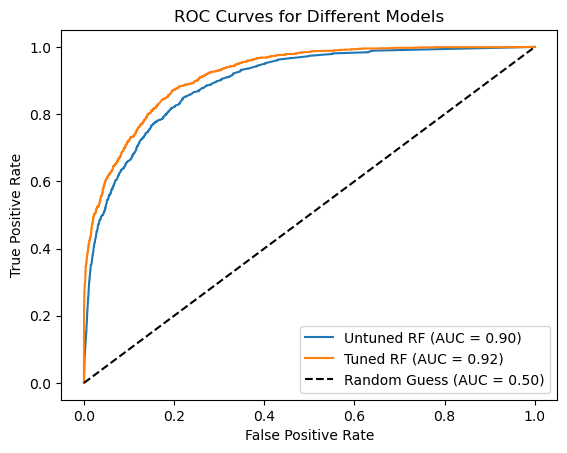

In [30]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
    
# Generate ROC AUC for untuned model
y_probs = rf_untuned.predict_proba(X_test)[:, 1]
fpr1, tpr1, thresholds = roc_curve(y_test, y_probs)
auc_score1 = auc(fpr1, tpr1)

# Generate ROC AUC for tuned model
y_probs = rf.predict_proba(X_test)[:, 1]
fpr2, tpr2, thresholds = roc_curve(y_test, y_probs)
auc_score2 = auc(fpr2, tpr2)

# Plot the ROC curve
plt.plot(fpr1, tpr1, label=f'Untuned RF (AUC = {auc_score1:.2f})')
plt.plot(fpr2, tpr2, label=f'Tuned RF (AUC = {auc_score2:.2f})')

# Draw Random Guess
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.50)')

# Modify Formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend()
plt.show()

In [ ]:
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)

base_model.score(X_test, y_tuned_model = RandomForestClassifier(n_estimators = 1200, min_samples_split=5, min_samples_leaf=2, max_depth=100, bootstrap=False, random_state = 42)
tuned_model.fit(X_train, y_train)

tuned_model.score(X_test, y_test)
#base_accuracy = evaluate(base_model, X_test, y_test)test)

#base_accuracy = evaluate(base_model, X_test, test_labels)

In [ ]:
tuned_model = RandomForestClassifier(n_estimators = 1200, min_samples_split=5, min_samples_leaf=2, max_depth=100, bootstrap=False, random_state = 42)
tuned_model.fit(X_train, y_train)

tuned_model.score(X_test, y_test)
#base_accuracy = evaluate(base_model, X_test, y_test)

In [ ]:
# Grid SEarch further tuning

In [ ]:
pd.DataFrame(zip(X.columns, tuned_model.feature_importances_), columns=["Feature Name", "Importance"]).set_index("Feature Name").plot.bar()

## Assignment 3: Gradient Boosting

1. Fit and Tune a GBM
2. Plot Feature Importance for your Tuned GBM - could we remove any features?
2. Plot the tuned GBM ROC curve vs your tuned Random Forest model and report AUC for each

In [33]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=2023)

params = {
    'n_estimators': np.arange(start=100, stop=1100, step=100),
    'learning_rate': [.001, .01, .1, .2],
    'max_features': [None, "sqrt"],
    'subsample': [.8, .9, 1.0],
    'max_depth': np.arange(start=3, stop=12, step=2),
    'min_samples_leaf': [2, 5, 10]    
}

grid = RandomizedSearchCV(
    gb, 
    params,
    n_iter=100,
    scoring="accuracy"
)

grid.fit(X_train, y_train)

grid.best_params_

{'subsample': 0.8,
 'n_estimators': 1000,
 'min_samples_leaf': 2,
 'max_features': None,
 'max_depth': 7,
 'learning_rate': 0.01}

In [36]:
grid.score(X_test, y_test)

0.8750781738586617

In [38]:
params = {
    'n_estimators': np.arange(start=950, stop=1101, step=25),
    'learning_rate': [.001, .01, .1, .2],
    'max_features': [None],
    'subsample': [.8],
    'max_depth': [7],
    'min_samples_leaf': [2, 5, 10, 20]    
}

grid = GridSearchCV(
    gb, 
    params,
    scoring="accuracy"
)

grid.fit(X_train, y_train)

grid.best_params_

{'learning_rate': 0.01,
 'max_depth': 7,
 'max_features': None,
 'min_samples_leaf': 2,
 'n_estimators': 1075,
 'subsample': 0.8}

In [40]:
grid.score(X_train, y_train)

0.9007505277147995

In [39]:
grid.score(X_test, y_test)

0.8750781738586617

In [44]:
gb_tuned = GradientBoostingClassifier(random_state=2023, **grid.best_params_)

gb_tuned.fit(X_train, y_train)

print(f"Training Accuracy: {gb_tuned.score(X_train, y_train)}")
print(f"Test Accuracy: {gb_tuned.score(X_test, y_test)}")

Training Accuracy: 0.9007505277147995
Test Accuracy: 0.8750781738586617


<Axes: xlabel='importance', ylabel='feature'>

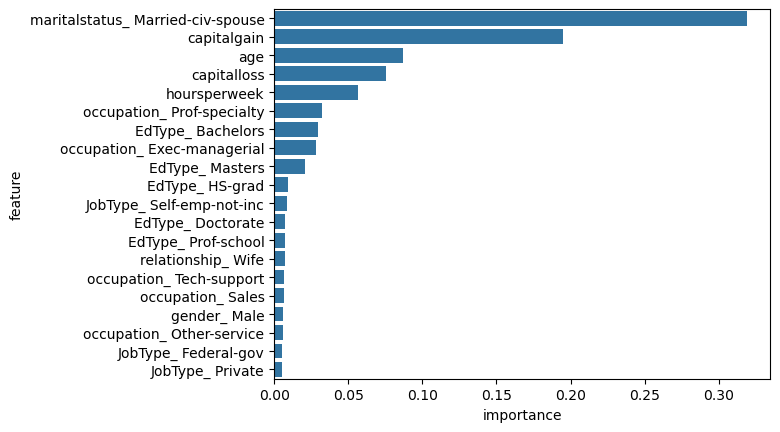

In [57]:
importance = pd.DataFrame(
    {"feature": X_train.columns, 
     "importance": gb_tuned.feature_importances_}
).sort_values("importance", ascending=False).iloc[:20]

sns.barplot(importance, x="importance", y="feature")

In [60]:
# Dropped Race, Native Country, 
gb_tuned = GradientBoostingClassifier(random_state=2023, **grid.best_params_)

gb_tuned.fit(X_train, y_train)

print(f"Training Accuracy: {gb_tuned.score(X_train, y_train)}")
print(f"Test Accuracy: {gb_tuned.score(X_test, y_test)}")

Training Accuracy: 0.9008677976702368
Test Accuracy: 0.8753908692933083


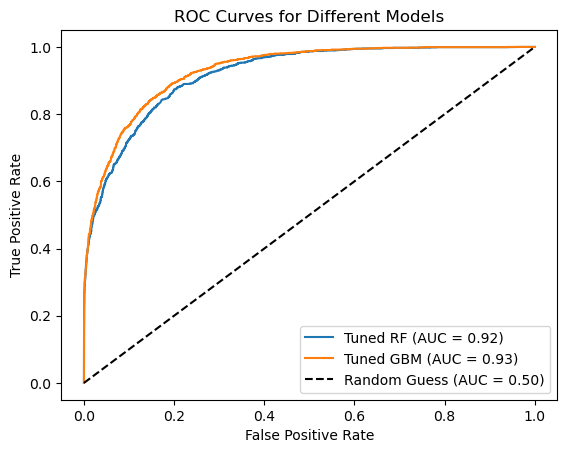

In [64]:
from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    
# Generate ROC AUC for random forest
y_probs = rf.predict_proba(X_test)[:, 1]
fpr1, tpr1, thresholds = roc_curve(y_test, y_probs)
auc_score1 = auc(fpr1, tpr1)

# Generate ROC AUC for gbm
y_probs = gb_tuned.predict_proba(X_test)[:, 1]
fpr2, tpr2, thresholds = roc_curve(y_test, y_probs)
auc_score2 = auc(fpr2, tpr2)

# Plot the ROC curve
plt.plot(fpr1, tpr1, label=f'Tuned RF (AUC = {auc_score1:.2f})')
plt.plot(fpr2, tpr2, label=f'Tuned GBM (AUC = {auc_score2:.2f})')

# Draw Random Guess
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.50)')

# Modify Formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend()
plt.show()